TODO Introduction

# Table of Contents

- [Introduction](#Introduction)
- [Environment](#Environment)
- [The Dataset](#The-Dataset)
    - [Gathering](#Gathering)
    - [Assessing](#Assessing)
    - [Cleaning](#Cleaning)

# Environment

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns

# The Dataset

## Gathering

Requesting CSV file from Udacity server:

In [2]:
data_url = "https://video.udacity-data.com/topher/2020/October/5f91cf38_201902-fordgobike-tripdata/201902-fordgobike-tripdata.csv"
data_http_response = requests.get(data_url)
data_http_response

<Response [200]>

Saving file locally for backup purposes:

In [3]:
data_path = "C://Users//anaju//Documents//Workspaces//nanodegree//bike-sharing//data//"

In [4]:
with open(os.path.join(data_path, "201902-fordgobike-tripdata.csv"), "w") as data_file:
    data_file.write(data_http_response.text)

Importing to a DataFrame:

In [5]:
df_rides = pd.read_csv(os.path.join(data_path, "201902-fordgobike-tripdata.csv"))
df_rides.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


## Assessing

- Wrong data types.
- Suspicious birth year (minimum is 1878).
- Rides with no info on start/end station.

In [6]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             183412 non-null  int64  
 1   start_time               183412 non-null  object 
 2   end_time                 183412 non-null  object 
 3   start_station_id         183215 non-null  float64
 4   start_station_name       183215 non-null  object 
 5   start_station_latitude   183412 non-null  float64
 6   start_station_longitude  183412 non-null  float64
 7   end_station_id           183215 non-null  float64
 8   end_station_name         183215 non-null  object 
 9   end_station_latitude     183412 non-null  float64
 10  end_station_longitude    183412 non-null  float64
 11  bike_id                  183412 non-null  int64  
 12  user_type                183412 non-null  object 
 13  member_birth_year        175147 non-null  float64
 14  memb

In [7]:
df_rides.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year
count,183412.000000,183215.000000,183412.000000,183412.000000,183215.000000,183412.000000,183412.000000,183412.000000,175147.000000
mean,726.078435,138.590427,37.771223,-122.352664,136.249123,37.771427,-122.352250,4472.906375,1984.806437
std,1794.389780,111.778864,0.099581,0.117097,111.515131,0.099490,0.116673,1664.383394,10.116689
min,61.000000,3.000000,37.317298,-122.453704,3.000000,37.317298,-122.453704,11.000000,1878.000000
25%,325.000000,47.000000,37.770083,-122.412408,44.000000,37.770407,-122.411726,3777.000000,1980.000000
50%,514.000000,104.000000,37.780760,-122.398285,100.000000,37.781010,-122.398279,4958.000000,1987.000000
75%,796.000000,239.000000,37.797280,-122.286533,235.000000,37.797320,-122.288045,5502.000000,1992.000000
max,85444.000000,398.000000,37.880222,-121.874119,398.000000,37.880222,-121.874119,6645.000000,2001.000000


In [8]:
sum(df_rides.duplicated())

0

In [9]:
df_rides.user_type.value_counts()

Subscriber    163544
Customer       19868
Name: user_type, dtype: int64

In [10]:
df_rides.member_gender.value_counts()

Male      130651
Female     40844
Other       3652
Name: member_gender, dtype: int64

In [11]:
df_rides.bike_share_for_all_trip.value_counts()

No     166053
Yes     17359
Name: bike_share_for_all_trip, dtype: int64

## Cleaning

In [12]:
df_rides_clean = df_rides.copy()

### Missing data

In [13]:
df_rides_clean = df_rides_clean.dropna().reset_index(drop=True)

### Wrong data types

#### `datetime` 

In [14]:
# start and end times must be datetime
datetime_vars = ['start_time', 'end_time']

In [15]:
for var in datetime_vars:
    df_rides_clean[var] = pd.to_datetime(df_rides_clean[var])

#### `int` 

In [16]:
# station IDs and member's birth year should be integer, instead of float
int_vars = ['start_station_id', 'end_station_id', 'member_birth_year']

In [17]:
for var in int_vars:
    df_rides_clean[var] = df_rides_clean[var].astype(int)

#### `CategoricalDtype`

In [18]:
# user type, member gender and bike shared for all trip should be unordered categorical variables
unordered_cat_vars = {
    'user_type': list(df_rides_clean.user_type.unique()),
    'member_gender': list(df_rides_clean.member_gender.unique())
}

In [19]:
for var in unordered_cat_vars:
    unordered_var = pd.api.types.CategoricalDtype(ordered = False, categories = unordered_cat_vars[var])
    df_rides_clean[var] = df_rides_clean[var].astype(unordered_var)

#### `bool`

In [20]:
df_rides_clean['bike_share_for_all_trip'] = df_rides_clean['bike_share_for_all_trip'].apply(lambda x: True if x == "Yes" else False)

### Invalid birth years

In [21]:
df_rides_clean.member_birth_year.sort_values().unique()

array([1878, 1900, 1901, 1902, 1910, 1920, 1927, 1928, 1930, 1931, 1933,
       1934, 1938, 1939, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948,
       1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001])

In [22]:
df_rides_clean = df_rides_clean[df_rides_clean.member_birth_year >= 1922]

# Feature Engineering

## Converting duration to minutes

In [23]:
def convert_sec_to_min(duration_sec):
    minutes, seconds = divmod(duration_sec, 60)
    return minutes

In [24]:
df_rides_clean['duration_min'] = df_rides_clean.duration_sec.apply(convert_sec_to_min)

In [25]:
df_rides_clean.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration_min
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984,Male,False,869
1,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86,Market St at Dolores St,37.769305,-122.426826,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972,Male,False,1030
2,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375,Grove St at Masonic Ave,37.774836,-122.446546,70,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989,Other,False,608
3,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7,Frank H Ogawa Plaza,37.804562,-122.271738,222,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974,Male,True,26
4,1793,2019-02-28 23:49:58.632,2019-03-01 00:19:51.760,93,4th St at Mission Bay Blvd S,37.770407,-122.391198,323,Broadway at Kearny,37.798014,-122.405950,5200,Subscriber,1959,Male,False,29


## Extract more info on the dates

### Start time

In [26]:
start_time_parts = {
    'start_time': df_rides_clean.start_time,
    'start_time_hour': df_rides_clean.start_time.dt.hour,
    'start_time_day': df_rides_clean.start_time.dt.day,
    'start_time_month': df_rides_clean.start_time.dt.month,
    'start_time_year': df_rides_clean.start_time.dt.year,
    'start_time_weekday': df_rides_clean.start_time.dt.day_name()
}

In [27]:
start_time_df = pd.DataFrame(start_time_parts)

In [28]:
start_time_df.head()

,start_time,start_time_hour,start_time_day,start_time_month,start_time_year,start_time_weekday
0,2019-02-28 17:32:10.145,17,28,2,2019,Thursday
1,2019-02-28 12:13:13.218,12,28,2,2019,Thursday
2,2019-02-28 17:54:26.010,17,28,2,2019,Thursday
3,2019-02-28 23:54:18.549,23,28,2,2019,Thursday
4,2019-02-28 23:49:58.632,23,28,2,2019,Thursday


In [29]:
df_rides_clean = df_rides_clean.merge(start_time_df, how='left', on='start_time')

In [30]:
df_rides_clean.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration_min,start_time_hour,start_time_day,start_time_month,start_time_year,start_time_weekday
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13,Commercial St at Montgomery St,37.794231,...,Customer,1984,Male,False,869,17,28,2,2019,Thursday
1,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86,Market St at Dolores St,37.769305,-122.426826,3,Powell St BART Station (Market St at 4th St),37.786375,...,Customer,1972,Male,False,1030,12,28,2,2019,Thursday
2,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375,Grove St at Masonic Ave,37.774836,-122.446546,70,Central Ave at Fell St,37.773311,...,Subscriber,1989,Other,False,608,17,28,2,2019,Thursday
3,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7,Frank H Ogawa Plaza,37.804562,-122.271738,222,10th Ave at E 15th St,37.792714,...,Subscriber,1974,Male,True,26,23,28,2,2019,Thursday
4,1793,2019-02-28 23:49:58.632,2019-03-01 00:19:51.760,93,4th St at Mission Bay Blvd S,37.770407,-122.391198,323,Broadway at Kearny,37.798014,...,Subscriber,1959,Male,False,29,23,28,2,2019,Thursday


### End time

In [31]:
end_time_parts = {
    'end_time': df_rides_clean.end_time,
    'end_time_hour': df_rides_clean.end_time.dt.hour,
    'end_time_day': df_rides_clean.end_time.dt.day,
    'end_time_month': df_rides_clean.end_time.dt.month,
    'end_time_year': df_rides_clean.end_time.dt.year,
    'end_time_weekday': df_rides_clean.end_time.dt.day_name()
}

In [32]:
end_time_df = pd.DataFrame(end_time_parts)

In [33]:
end_time_df.head()

,end_time,end_time_hour,end_time_day,end_time_month,end_time_year,end_time_weekday
0,2019-03-01 08:01:55.975,8,1,3,2019,Friday
1,2019-03-01 05:24:08.146,5,1,3,2019,Friday
2,2019-03-01 04:02:36.842,4,1,3,2019,Friday
3,2019-03-01 00:20:44.074,0,1,3,2019,Friday
4,2019-03-01 00:19:51.760,0,1,3,2019,Friday


In [34]:
df_rides_clean = df_rides_clean.merge(end_time_df, how='left', on='end_time')

In [35]:
df_rides_clean.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,start_time_hour,start_time_day,start_time_month,start_time_year,start_time_weekday,end_time_hour,end_time_day,end_time_month,end_time_year,end_time_weekday
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13,Commercial St at Montgomery St,37.794231,...,17,28,2,2019,Thursday,8,1,3,2019,Friday
1,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86,Market St at Dolores St,37.769305,-122.426826,3,Powell St BART Station (Market St at 4th St),37.786375,...,12,28,2,2019,Thursday,5,1,3,2019,Friday
2,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375,Grove St at Masonic Ave,37.774836,-122.446546,70,Central Ave at Fell St,37.773311,...,17,28,2,2019,Thursday,4,1,3,2019,Friday
3,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7,Frank H Ogawa Plaza,37.804562,-122.271738,222,10th Ave at E 15th St,37.792714,...,23,28,2,2019,Thursday,0,1,3,2019,Friday
4,1793,2019-02-28 23:49:58.632,2019-03-01 00:19:51.760,93,4th St at Mission Bay Blvd S,37.770407,-122.391198,323,Broadway at Kearny,37.798014,...,23,28,2,2019,Thursday,0,1,3,2019,Friday


In [36]:
df_rides_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174969 entries, 0 to 174968
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             174969 non-null  int64         
 1   start_time               174969 non-null  datetime64[ns]
 2   end_time                 174969 non-null  datetime64[ns]
 3   start_station_id         174969 non-null  int32         
 4   start_station_name       174969 non-null  object        
 5   start_station_latitude   174969 non-null  float64       
 6   start_station_longitude  174969 non-null  float64       
 7   end_station_id           174969 non-null  int32         
 8   end_station_name         174969 non-null  object        
 9   end_station_latitude     174969 non-null  float64       
 10  end_station_longitude    174969 non-null  float64       
 11  bike_id                  174969 non-null  int64         
 12  user_type       

## Getting people's generations

https://www.beresfordresearch.com/age-range-by-generation/

In [37]:
gen_labels = ['WW II', 'Post War', 'Boomers I', 'Boomers II', 'Gen X', 'Millenials', 'Gen Z']
gen_birth_years = [1922, 1927, 1945, 1954, 1964, 1980, 1996, 2012]

In [38]:
df_rides_clean['member_gen'] = pd.cut(df_rides_clean['member_birth_year'], gen_birth_years, labels=gen_labels, include_lowest=True, right=True)

In [39]:
member_gen_var = pd.api.types.CategoricalDtype(ordered=False, categories=list(df_rides_clean.member_gen.unique()))
df_rides_clean['member_gen'] = df_rides_clean['member_gen'].astype(member_gen_var)

In [40]:
df_rides_clean.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,start_time_day,start_time_month,start_time_year,start_time_weekday,end_time_hour,end_time_day,end_time_month,end_time_year,end_time_weekday,member_gen
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13,Commercial St at Montgomery St,37.794231,...,28,2,2019,Thursday,8,1,3,2019,Friday,Millenials
1,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86,Market St at Dolores St,37.769305,-122.426826,3,Powell St BART Station (Market St at 4th St),37.786375,...,28,2,2019,Thursday,5,1,3,2019,Friday,Gen X
2,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375,Grove St at Masonic Ave,37.774836,-122.446546,70,Central Ave at Fell St,37.773311,...,28,2,2019,Thursday,4,1,3,2019,Friday,Millenials
3,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7,Frank H Ogawa Plaza,37.804562,-122.271738,222,10th Ave at E 15th St,37.792714,...,28,2,2019,Thursday,0,1,3,2019,Friday,Gen X
4,1793,2019-02-28 23:49:58.632,2019-03-01 00:19:51.760,93,4th St at Mission Bay Blvd S,37.770407,-122.391198,323,Broadway at Kearny,37.798014,...,28,2,2019,Thursday,0,1,3,2019,Friday,Boomers II


In [41]:
for gen in df_rides_clean.member_gen.cat.categories:
    years = df_rides_clean.query("member_gen == @gen")['member_birth_year'].sort_values().unique()
    print(gen, years)

Millenials [1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996]
Gen X [1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978
 1979 1980]
Boomers II [1955 1956 1957 1958 1959 1960 1961 1962 1963 1964]
Gen Z [1997 1998 1999 2000 2001]
Boomers I [1946 1947 1948 1949 1950 1951 1952 1953 1954]
Post War [1928 1930 1931 1933 1934 1938 1939 1941 1942 1943 1944 1945]
WW II [1927]


In [42]:
df_rides_clean.to_csv('../data/fordgobike_clean.csv', index=False)

# Univariate Exploration

## Trip Duration

In [58]:
df_rides_clean.duration_min.describe(percentiles=[.25, .5, .75, .999])

count    174969.000000
mean         11.241563
std          27.369843
min           1.000000
25%           5.000000
50%           8.000000
75%          13.000000
99.9%       332.000000
max        1409.000000
Name: duration_min, dtype: float64

In [59]:
df_rides_clean[df_rides_clean['duration_min'] >= 60]['duration_min'].count()

1386

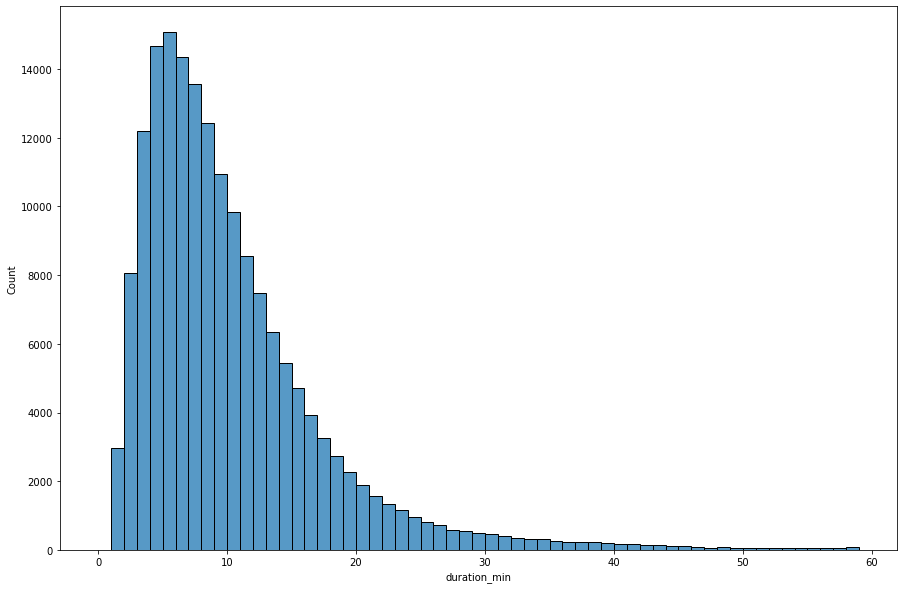

In [61]:
# define our figure
plt.figure(figsize=(15, 10))

# bin sizes
duration_min_bins = np.arange(0, 60, 1)

# plotting
sns.histplot(df_rides_clean, x='duration_min', bins=duration_min_bins)

# finishing
plt.show()

## Time of the day

## Day of the week